In [1]:
using Revise
using Pkg; Pkg.activate(".")

using Dates
using Statistics
using Rotations
using Interpolations
using DSP
using FFTW
using NCDatasets
using JLD2
using Printf

include("./read_lidar.jl")
using .read_lidar
using .read_lidar.stare
using .read_vecnav: read_vecnav_dict
import .chunks
include("./timing_lidar.jl")
using .timing_lidar
include("./readers.jl")
using .NoaaDas: cat_dicts
# using MAT

using PyPlot
using PyCall
using PyCall: PyObject

# PyObject method interprets Array{Union{T,Missing}} as a
# numpy masked array.
# This allows for plotting with missing values.
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

  Activating project at `~/Projects/ASTRAL/lidar`


PyObject

### Transform from ship inertial (external) to a lidar body (gimbaled) frame

Paraphrasing VectorNav paragraph on their coordinate system,
> There are many different combinations of Euler angles, however, the (3-2-1) set of Euler angles corresponding to yaw-pitch-roll is considered to be the standard, especially in terrestrial applications. These rotations are applied sequentially in a particular order, with each rotation specified about the specified body frame axis as it exists following the previous rotations. Figure 2.5a shows the body frame and NED frame initially aligned. Figure 2.5b shows the yaw rotation around the [original] Z1-axis. This is followed in Figure 2.5c by the pitch rotation about the new Y2-axis. Finally, there is a roll rotation about the newest X3-axis in Figure 2.5d to achieve the final orientation of the aircraft.

[https://www.vectornav.com/resources/inertial-navigation-primer/math-fundamentals/math-attituderep#:~:text="Euler%20Angles%20(Yaw%2DPitch%2D,final%20orientation%20of%20the%20aircraft."](https://www.vectornav.com/resources/inertial-navigation-primer/math-fundamentals/math-attituderep#:~:text="Euler%20Angles%20(Yaw%2DPitch%2D,final%20orientation%20of%20the%20aircraft.")

Then from (https://www.vectornav.com/resources/inertial-navigation-primer/examples/atttransform)[https://www.vectornav.com/resources/inertial-navigation-primer/examples/atttransform] the rotation matrix is formed by a series of left-multiplications, with the first rotation being the yaw (Z1) rotation.

In [2]:
# function library with utility functions,  functions for subsetting, for displacements, and for structure functions

# utility functions
pd = permutedims
m2n(x) = ismissing(x) ? NaN : x
good(x) = !ismissing(x) & isfinite(x)

"""
    binavg(y, x, b; f=identity, w=y->1)
Bin average y(x) in bins b of coordinate x.
Skip missing by passing the optional function arguments
f(y) = ismissing(y) ? 0 : y;   w(y) = !ismissing(y)
"""
function binavg(y, x, b; f=identity, w=y->1)
    a = zeros(length(b))
    c = zeros(length(b))
    for (i,x) in enumerate(x)
        bi = findlast(j -> j < x, b) # findlast(<(x), b)
        a[bi] += f(y[i])
        c[bi] += w(y[i])
    end
    return a./c
end

# functions for masking and averaging data

"NaN -> missing"
n2m(x) = isfinite.(x) ? x : missing

"result is x; set to missing iff i<thr"
masklowi(x, i, thr=1.03) = i<thr ? missing : x

"mean along dimension dims, skipping missing"
missmean(X; dims=1) = mapslices(x -> mean(skipmissing(x)), X, dims=dims)

"anomaly"
anom(x; dims=1) = x.-mean(x; dims=dims)

# highpass filter
"""
hp(x, fcutoff=1/80)    highpass filter x,
by default filtfilt 4th-order Butterworth, fs=1
"""
function hp(x, fcutoff=1/80;
    order=4,
    designmethod=Butterworth(order), 
    fs=1,
    responsetype = Highpass(fcutoff; fs=fs) )
    
    filtfilt(digitalfilter(responsetype, designmethod), x)
end


# make simple linear temporal interpolation
# maybe fast
# most time is spent searching for indices
# indices are monotonic

"""
Return all the indices i such that each xl[i] is the first >= each xs.
Assumes xs, xl are ordered and loops through xs only once.
Quarry for needles xs in haystack xl.
"""
function findindices(xs, xl)
    # needles xs define quarries in haystack xl
    xs = filter(x -> x<=last(xl), xs) # prefilter to avoid running off the end of xl
    ind = zeros(Int64, size(xs))
    i = 1
    for (j,x) in enumerate(xs)
        while xl[i] < x
            i += 1
        end
        ind[j] = i
    end
    return ind
end

"average xl within windows to right of points of the index ind of xl"
function indavg(xl, ind; full=20)
    xm = zeros(Float64, size(ind))
    for (i,idx) in enumerate(ind)
        ii = max(1,idx) : min(length(xl),idx+full)
        # xm[i] = sum(Float64.(xl[ii])) / (full+1)
        xm[i] = mean(Float64.(xl[ii]))
    end
    return xm
end

# test data (precompiles)
let xl = 1:60_000_000, xs = 20:20:60_000_000
    ind = findindices(xs, xl)
    indavg(xl, ind)
end

# Adjust true vertical velocity for relative wind * sin(tilt)
# and the platform velocity
trigs(pitch, roll) = ( cos(pitch), sin(pitch), cos(roll), sin(roll) )
# cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)

function wtrue_trigs(w, Ur, Vr, pitch, roll)
    # approximate, better to use rotations
    cospitch, sinpitch, cosroll, sinroll = trigs(pitch, roll)
    wtrue = ( w + Ur*sinpitch - Vr*cospitch*sinroll ) / (cospitch*cosroll)
end

"""
wtrue(dopplervel, Ur, Vr, heaveveldown, roll, pitch)
Return true radial velocity component in lidar beam frame (+away).
Rotate vertical VelNED and mean ship-relative wind (Ur, Vr)
from inertial level ship coorindates 
to lidar beam coordinates using roll and pitch.
"""
function wtrue( dopplervel, Ur, Vr, heaveveldown, roll, pitch )
    # external ship frame
    vvn_ship = [0, 0, heaveveldown] # VectorNav vertical velocity vector (NED coordinate)
    wnd_ship = [Ur, Vr, 0]          # mean horizontal relative wind, w=0 (NED coordinate)
    wnd_vn_ship = wnd_ship - vvn_ship

    # rotate from ship NED frame to lidar NED frame
    R = RotX(roll*π/180) * RotY(pitch*π/180)

    # mean vertical-radial-lidar relative velocity in the lidar platform body frame (NED)
    # includes heave-induced velocity
    wnd_lidar =  R * wnd_vn_ship # lidar NED frame (down-positive) vector

    # signs: lidar upward heave vel > 0 ==> lidar VelNED2 < 0, induced radial velocity < 0 (towards)

    # scalar true radial velocity (+up), adjusting for heave velocity
    # and mean wind component in beam direction.
    # wturb and dopplervel is away-positive. true radialvel is dopplervel + platform vel
    # wtrue = wrel + wplatform
    # trueradialvel is +up
    trueradialvel = dopplervel + -wnd_lidar[3] # negate downward wnd_lidar: NED +down, dopplervel +up
end

function wtrue( dopplervel, surgevel, swayvel, heaveveldown, Ur, Vr, roll, pitch )
    # external ship frame
    vvn_ship = [surgevel, swayvel, heaveveldown] # VectorNav vertical velocity vector (NED coordinate)
    #vvn_ship = [VelNED0, VelNED1, VelNED2]
    wnd_ship = [Ur, Vr, 0]          # mean horizontal relative wind, w=0 (NED coordinate)
    wnd_vn_ship = wnd_ship - vvn_ship

    # rotate from ship NED frame to lidar NED frame
    R = RotX(roll*π/180) * RotY(pitch*π/180)

    # mean vertical-radial-lidar relative velocity in the lidar platform body frame (NED)
    # includes heave-induced velocity
    wnd_lidar =  R * wnd_vn_ship # lidar NED frame (down-positive) vector

    # signs: lidar upward heave vel > 0 ==> lidar VelNED2 < 0, induced radial velocity < 0 (towards)

    # scalar true radial velocity (+up), adjusting for heave velocity
    # and mean wind component in beam direction.
    # wturb and dopplervel is away-positive. true radialvel is dopplervel + platform vel
    # wtrue = wrel + wplatform
    # trueradialvel is +up
    trueradialvel = dopplervel + -wnd_lidar[3] # negate downward wnd_lidar: NED +down, dopplervel +up
end

# functions for indexing sample pairs for structure functions

# generate unique pairs of indices
"index unique pairs in a vector of length n"
function uniquepairs(n) 
    [ [l1, l2] for l1 in 1:n for l2 in (l1+1):n ]
end
"index pairs of points in adjacent levels"
allcross(n) = [ [l1, l2] for l1 in 1:n for l2 in 1:n ]

# beam geometry
"lidar beam range"
rng(iz, rangegate=24.0) = rangegate * (iz-1 + 0.5)

"""
compile indices of lidar volumes to be compared with
structure functions
"""
function lidarindices(nt, nz, z1=1; nlevelstats=1)
    if nlevelstats == 3
        # The complete set that doesn't repeat pairs is 
        # 1 the complete set of nt*(n-1)/2 pairs for the top level (3)
        # 2 the 2*nt*nt sets of pairs between every point in top (3) level and the next 2 levels
        # Iteratively slide this box upward by 1 level for each level.
    
        # index pairs in middle level 2-2
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r22 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r22 = CartesianIndex.(tuple.(it2,z1)) # 2nd 
    
        # index pairs of points from level 2-1, and 2-3
        ac = allcross(nt)
        it1 = map(i->i[1], ac)
        it2 = map(i->i[2], ac)
        ci1_r21 = ci1_r23 = CartesianIndex.(tuple.(it1,2))
        ci2_r21 = CartesianIndex.(tuple.(it2,z1-1))
        ci2_r23 = CartesianIndex.(tuple.(it2,z1+1))
    
        # omnibus set of cartesian index pairs for a level, including points in lev above and below
        ci1 = [ci1_r23; ci1_r22; ci1_r21] # first of pairs
        ci2 = [ci2_r23; ci2_r22; ci2_r21]
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
        
    elseif nlevelstats == 1
        # just use structure function velocity pairs from one level of lidar range
        up = uniquepairs(nt)
        it1 = map(i->i[1], up) # time indices for pairs of point1, point2
        it2 = map(i->i[2], up)
        ci1_r11 = CartesianIndex.(tuple.(it1,z1)) # 1st point in pair lev
        ci2_r11 = CartesianIndex.(tuple.(it2,z1)) # 2nd point in same lev
    
        # set of cartesian index pairs for a level, including points in lev above and below
        ci1 = ci1_r11 # first of pairs
        ci2 = ci2_r11
        li1 = LinearIndices(ci1)
        li2 = LinearIndices(ci2)
    end
    
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second
    
    return ci1,ci2, li1,li2, it1,iz1,it2,iz2
end

# try example
ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(1000, 80)

# functions for displacments and structure functions 

rangegate = 24.0 # for ASTRAL 2024 Halo Photonics StreamLineXR

"""
zm, dr2, dz2, D2 = displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate)
Displacements of sample pairs for one (vertical) subvolume.
"""
function displacements( ci1,ci2, Udt,Vdt, pitch,roll, w; rangegate=rangegate , timestep=timestep)
    # get the individual indices
    it1 = map(idx->idx[1], ci1) #  t index of first point(s)
    iz1 = map(idx->idx[2], ci1) #  z index of first
    it2 = map(idx->idx[1], ci2) #  t       of second points(s)
    iz2 = map(idx->idx[2], ci2) #  z          second

    rng(iz) = rangegate * (iz-1 + 0.5) # center of gates

    # horiz translation of the sample volumes by mean wind
    Udtbar = @. (Udt[iz2] + Udt[iz1]) / 2
    Vdtbar = @. (Vdt[iz2] + Vdt[iz1]) / 2
    X = @. Udtbar * (it2 - it1)
    Y = @. Vdtbar * (it2 - it1)
    # vertical middle of pair
    zm = @. (rng(iz2) * cos(pitch[it2])*cos(roll[it2]) + rng(iz1) * cos(pitch[it1])*cos(roll[it1])) / 2
    # displacement between pair of points
    dz = @.     rng(iz2) * cos(pitch[it2])*cos(roll[it2]) - rng(iz1) * cos(pitch[it1])*cos(roll[it1])
    dx = @. X + rng(iz2) *-sin(pitch[it2])                - rng(iz1) *-sin(pitch[it1])
    dy = @. Y + rng(iz2) * cos(pitch[it2])*sin(roll[it2]) - rng(iz1) * cos(pitch[it1])*sin(roll[it1])
    # distance between
    dz2 = dz .* dz
    dr2 = @. dz2 + dx*dx + dy*dy
    # CORRECT W for HEAVE and for TILTING into the horizontal wind
    # vel structure function
    D2 = @. (w[ci2] - w[ci1])^2
    # return properties of pairs
    return zm, dr2, dz2, D2
end

"dr^2/3 (1-(dz/dr)^2/4) displacement function for computing dissipation from structure function pairs"
rhopair(dr2, dz2) = dr2^(1/3) * (1 - dz2/(4*dr2))

rhopair

In [3]:
# functions for subsetting and finding the offset with max covariance
# newer: 2025-02

"""
return indices jl, js to subset windows dtl[jl], dts[js] st. 
limdtl[1]+offset <= dtl[jl] <= limdtl[2]+offset
limdtl[1]        <= dts[js] <= limdtl[2]
offset shifts the window in the long step coordinates
"""
# use with code for chunks found elsewhere
function offset_subset(dtl, dts, limdtl, offset=eltype(limdtl)(0))
    # index the long data set (gappy Halo) with absolute time deltas
    jl = findall(limdtl[1] .<= dtl-offset .<= limdtl[2])
    # comb the time indices out of VN dts
    js = findindices(dtl[jl] .- offset, dts) # findindices( needles, haystack )
    return jl, js
end

function offset_cov(dtl, dts, limdtl, offset, yl, ys)
    jl, js = offset_subset(dtl, dts, limdtl, offset)
    # try
    #     ii = isfinite.(yl[jl]) .&& isfinite.(ys[js]) # skip NaNs # sometimes breaks: arrays not broadcast to consistent size
    #     yl[jl][ii]
    # catch
    #     print("limdtl=$(limdtl) offset=$(offset) jl($(length(jl))), js($(length(js)))")
    # end
    # return cov = mean( skipmissing(yl[jl][ii] .* ys[js][ii]) ) # skip missings
    nn = @. good(yl[jl]) & good(ys[js])
    a_cov = cov(yl[jl][nn], ys[js][nn])
    # a_cov = mean( skipmissing(anom(yl[jl]) .* anom(ys[js])) ) # skip missings
    return a_cov
end

"find optimal offset timedelta (seconds) that syncs yl, ys"
function offset_range_covs(dtl, dts, limdtl, rangeoffset, yl, ys)
    covs = [ offset_cov(dtl, dts, limdtl, offset, yl, ys) 
                for offset in rangeoffset ]
end

"""
return the time offset that syncs dtl (Halo) and dts (VN) for the 
window limdt=[chunkdtstart, chunkdtend]
"""
function sync_offset(dtl, dts, yl, ys, limdt, rangeoffset=Second(0):Second(1):Second(200))
    rangecovs = offset_range_covs(dtl, dts, limdt, rangeoffset, yl, ys)
    maxcov, fm = findmax(rangecovs)
    bestoffset = rangeoffset[fm]
    return bestoffset, maxcov, std(rangecovs)
end

# load input data for doing the offset calculations
"load VN and 1 day of lidar timeangles"
function load_vn_lidar_data(thisdt, Vn=read_vecnav_dict())
    dts = Vn[:vndt] # short timesteps
    ys = Vn[:Roll]  # short-step data

    # read the lidar time axis for this day
    dtstamp = Dates.format(thisdt, dateformat"yyyymmdd")
    datapath = joinpath.(pwd(),"data",dtstamp)
    files = filter(startswith("Stare"), readdir(datapath))
    fullfiles = joinpath.(datapath, files)
    # also read the first hour of the next day
    nextdt = thisdt + Day(1)
    nextdatapath = joinpath.(pwd(), "data", Dates.format(nextdt, "yyyymmdd"))
    if isdir(nextdatapath)
        hour00 = readdir( nextdatapath ) |> filter(startswith("Stare")) |> filter(endswith("_00.hpl"))
        full25files = [fullfiles ; joinpath(nextdatapath, hour00[1])]
    else
        full25files = fullfiles
    end
    # read all times in those files
    ta, _, _ = read_lidar.read_streamlinexr_beam_timeangles(full25files)
    tatime = ta[:time] # lidar time axis, hours
    i20 = findfirst(tatime .> 20.0)
    wrap = (i20-1) .+ findall( tatime[i20:end] .< 5 )
    tatime[wrap] .+= 24.0 # increment wrapped times from next day by 24 h
    dtl = @. thisdt + Millisecond(round(Int64, tatime * 3_600_000)) # long timesteps
    yl = ta[:pitch] # long-step data
    return dtl, yl, dts, ys
end

load_vn_lidar_data

In [4]:
# read VectorNav
Vn = read_vecnav_dict()

Dict{Symbol, Vector} with 22 entries:
  :LinAcc1  => Float32[0.28455, -0.563547, 0.545289, -0.615101, 0.663306, -0.17…
  :Roll     => Float32[-0.684141, -0.711255, -0.714359, -0.761043, -0.767432, -…
  :Latitude => Float32[16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16.2633, 16…
  :vndt     => [DateTime("2024-04-29T05:25:42.128"), DateTime("2024-04-29T05:25…
  :time     => [DateTime("2023-03-29T13:17:44"), DateTime("2023-03-29T13:17:44"…
  :Yaw      => Float32[-162.59, -162.574, -162.565, -162.549, -162.541, -162.53…
  :VelNED1  => Float32[5.05222, 5.04132, 5.05353, 5.04639, 4.93381, 4.93558, 4.…
  :MagNED2  => Float32[0.09548, 0.100129, 0.09543, 0.095481, 0.093838, 0.09533,…
  :Altitude => Float32[-43.986, -43.986, -43.986, -43.986, -44.212, -44.212, -4…
  :Quat1    => Float32[0.005692, 0.005927, 0.005941, 0.006337, 0.006396, 0.0065…
  :VelNED2  => Float32[-0.280547, -0.279673, -0.27213, -0.271012, -0.272294, -0…
  :MagNED0  => Float32[0.234275, 0.237392, 0.23345, 0.236116, 0.233466,

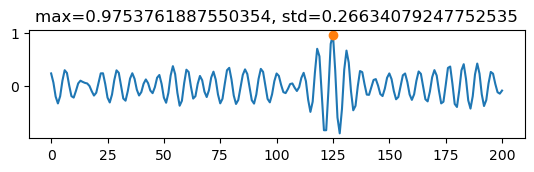

In [5]:
# procedural test of windowing and timing offsets 
rangeoffset = -Second(0):Second(1):Second(200)

thisdt = DateTime(2024,6,8) # select day
dtl, yl, dts, ys = load_vn_lidar_data(thisdt, Vn)

limdt = thisdt + Hour(1) + Minute(1) .+ Minute.([0, 3])

# test computing one covariance
offset = Second(126)

jl = findall(limdt[1] .<= dtl-offset .<= limdt[2])
# comb the time indices out of VN dts
js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
nn = @. good(yl[jl]) & good(ys[js])
a_cov = cov(yl[jl][nn], ys[js][nn])

# test computing a range of covariances
rangecovs = Vector{Float64}(undef, length(rangeoffset))
for (i, offset) in enumerate(rangeoffset)
    jl = findall(limdt[1] .<= dtl-offset .<= limdt[2])
    # comb the time indices out of VN dts
    js = findindices(dtl[jl] - offset, dts) # findindices( needles, haystack )
    nn = @. good(yl[jl]) & good(ys[js])
    rangecovs[i] = cov(yl[jl][nn], ys[js][nn])
end
maxcov, imax = findmax(rangecovs)

clf()
subplot(3,1,1)
plot(Dates.value.(rangeoffset), rangecovs)
plot(Dates.value.(rangeoffset[imax]), maxcov, marker="o")
title("max=$(maxcov), std=$(std(rangecovs))")
gcf()

Positive offsets make the l window select from forward in the original l timeseries, 
and shift the data in this window backward to compare with an earlier 
(0-offset) time in the s series.
Thus l signals are advanced to earlier times to align with earlier (0 offset).
signals in the s series. 

This disagram depicts the alignment of the windows of the
Halo and VectorNav data windows.
```
                 ---> time
Halo    l   ---|----signals |ere----        Halo time series with |requested window|
            --->>>>[signals here]---   >>>> offset
            ---[signals here]<<<<---   <<<< aligns later l data with s data
            ---[vecnavs gnal]-------        nearest points to nonmissing data in window
VecNav  s   ---|vecnavsignal|-------
```

In [6]:
# get all the files, and all the unique hours of the files
allstarefiles = vcat( [ joinpath.("data",F, 
    filter( startswith(r"Stare_"), readdir(joinpath("data",F)) ) ) 
  for F in filter( startswith(r"20240"), readdir("data") ) ]... )

REm = match.(r"Stare_116_(\d{8}_\d{2}).hpl", allstarefiles)
dth = [ DateTime(r[1], dateformat"yyyymmdd_HH") for r in REm ]
unique(floor.(dth, Hour)) # all 991 are already unique

# also linked in ./data/all

967-element Vector{DateTime}:
 2024-04-28T00:00:00
 2024-04-28T01:00:00
 2024-04-28T02:00:00
 2024-04-28T03:00:00
 2024-04-28T04:00:00
 2024-04-28T05:00:00
 2024-04-28T06:00:00
 2024-04-28T07:00:00
 2024-04-28T08:00:00
 2024-04-28T09:00:00
 ⋮
 2024-06-12T22:00:00
 2024-06-12T23:00:00
 2024-06-13T00:00:00
 2024-06-13T01:00:00
 2024-06-13T02:00:00
 2024-06-13T03:00:00
 2024-06-13T04:00:00
 2024-06-13T05:00:00
 2024-06-13T06:00:00

In [7]:
# get all times and a main list of chunks
# regardless of Stare file boundaries

# indices of gaps to find stare chunks
function stare.all_gaps(dt::Vector{DateTime})
    ien = findall( diff(dt) .> Second(36) )
    ist = ien .+ 1
    return ien, ist
end

if isfile("lidar_dt.jld2") 
    LidarDt = load("lidar_dt.jld2")
    # Dict: DateTime of each beam and indices of the start and end of staring chunks.
else
    # load and catenate time from the many Stare hpl files
    # construct and save a time vector of datetimes for all lidar beams
    # moved to save_lidar_dt.jl
    starefiles = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir, "all")))
    ff = joinpath.(lidarstemdir, "all", starefiles)
    ta, _,_ = read_lidar.read_streamlinexr_beam_timeangles(ff) # slow
    
    day0 = floor(ta[:start_time][1], Day)
    dtime = day0 .+ Millisecond.(round.(Int64, 3600_000 .* ta[:time]))
    for j in findall(diff(ta[:time]) .< -1.0)
        dtime[(j+1):end] .+= Day(1) # increment days
    end

    ien, ist = all_gaps(dtime)
    ist = [1; ist]
    ien = [ien; length(dtime)]
    # [ist ien]
    
    @save "lidar_dt.jld2" dtime ist ien
    LidarDt = load("lidar_dt.jld2")
end

Dict{String, Any} with 3 entries:
  "ist"   => [1, 244, 781, 1318, 1855, 2392, 2929, 3449, 3986, 4523  …  3091963…
  "dtime" => [DateTime("2024-04-28T00:00:18.840"), DateTime("2024-04-28T00:00:1…
  "ien"   => [243, 780, 1317, 1854, 2391, 2928, 3448, 3985, 4522, 5059  …  3092…

In [8]:
# fix ist, ien
if false # only needs to be fixed once
    dtime = LidarDt["dtime"]
    ien, ist = all_gaps(LidarDt["dtime"]) # the gaps
    # cat first and last time indices
    ist = [1; ist]
    ien = [ien; length(dtime)]
    # [ist ien]
    @save "lidar_dt.jld2" dtime ist ien
end

In [9]:
# part out the data among the individual files
lidarstemdir = "./data"
starefiles = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir, "all")))
ff = joinpath.(lidarstemdir, "all", starefiles)

if isfile("file_beam_inds.jld2")
    FileInds = load("file_beam_inds.jld2")
else # slow reload
    nfiles = length(ff)
    nbeams = zeros(Int32, nfiles)
    ngates = -1
    nheaderlines = 17
    # read number of lines for each file
    for (i,file) in enumerate(ff)
        h = read_lidar.read_streamlinexr_head(file)
        nlines = h[:nlines]
        ngates = h[:ngates]
        # beams could be rays or times
        nbeams[i] = round(Int, (nlines - nheaderlines) / (1+ngates)) # number of beams for each file
    end

    # indices for files slices
    bigind_file_end   = cumsum(nbeams)
    bigind_file_start = [0; bigind_file_end[1:end-1]] .+ 1

    # times, ibeam1, nbeams, hdr = read_lidar.read_streamlinexr_beam_times(ff) # slow bc. it rereads times
    # all( bigind_file_start .== ibeam1 ) # should be true
    [bigind_file_start nbeams bigind_file_end]
    @save "file_beam_inds.jld2" bigind_file_start nbeams bigind_file_end
    FileInds = load("file_beam_inds.jld2")
end

length(LidarDt["dtime"]) == FileInds["bigind_file_end"][end] # should be true

true

In [10]:
# load indices
LidarDt = load("lidar_dt.jld2")
# FileInds = load("file_beam_inds.jld2")

Dict{String, Any} with 3 entries:
  "ist"   => [1, 244, 781, 1318, 1855, 2392, 2929, 3449, 3986, 4523  …  3091963…
  "dtime" => [DateTime("2024-04-28T00:00:18.840"), DateTime("2024-04-28T00:00:1…
  "ien"   => [243, 780, 1317, 1854, 2391, 2928, 3448, 3985, 4522, 5059  …  3092…

In [11]:
# define periodic data types

# PeriodicVector periodically indexes
struct PeriodicVector{T}
    data::Vector{T}
end

# convenience constructor
PeriodicVector{T}(x, n::Integer) where {T} =
    PeriodicVector{T}(fill(x, n))

Base.length(p::PeriodicVector) = length(p.data)

Base.getindex(p::PeriodicVector, i::Integer) =
    p.data[mod1(i, length(p.data))]

Base.setindex!(p::PeriodicVector, v, i::Integer) =
    (p.data[mod1(i, length(p.data))] = v)

Base.iterate(P::PeriodicVector, state...) = iterate(P.data, state...)
Base.show(io::IO, P::PeriodicVector) = show(io, P.data)

# PeriodicMatrix periodically indexes the first dimension
struct PeriodicMatrix{T}
    data::Matrix{T}
end

PeriodicMatrix{T}(x, nrows::Integer, ncols::Integer) where {T} =
    PeriodicMatrix{T}(fill(x, nrows, ncols))

Base.size(P::PeriodicMatrix) = size(P.data)

# Periodic getindex
Base.getindex(P::PeriodicMatrix, i::Integer, j::Integer) =
    P.data[mod1(i, size(P.data, 1)), j]

# Periodic setindex!
Base.setindex!(P::PeriodicMatrix, v, i::Integer, j::Integer) =
    (P.data[mod1(i, size(P.data, 1)), j] = v)

# add iteration, show
Base.iterate(P::PeriodicMatrix, state...) = iterate(P.data, state...)
Base.show(io::IO, P::PeriodicMatrix) = show(io, P.data)


In [12]:
"initialize a beams Dict with exactly nbeams beams with periodic 1st (time) index"
function init_periodic_beams(nbeams, ngates)
    beams = Dict(
        :time       => PeriodicVector{Union{Float32,Missing}}(missing, nbeams), # decimal hours
        :azimuth    => PeriodicVector{Union{Float32,Missing}}(missing, nbeams), # degrees
        :elevangle  => PeriodicVector{Union{Float32,Missing}}(missing, nbeams),
        :pitch      => PeriodicVector{Union{Float32,Missing}}(missing, nbeams),
        :roll       => PeriodicVector{Union{Float32,Missing}}(missing, nbeams),
        :height     => PeriodicVector{Union{Float32,Missing}}(missing, ngates), # center of gate
        :dopplervel => PeriodicMatrix{Union{Float32,Missing}}(missing, nbeams,ngates), # m/s
        :intensity  => PeriodicMatrix{Union{Float32,Missing}}(missing, nbeams,ngates), # SNR + 1
        :beta       => PeriodicMatrix{Union{Float32,Missing}}(missing, nbeams,ngates) # m-1 sr-1  backscatter?
        )
end

# periodic buffer loop for data
nx = 4000 
nz = 80
x = zeros(nx,nz) # Doppler vel, backscatter, etc.
P = PeriodicMatrix( x )
dtx = PeriodicVector( fill(DateTime(0), nx) )

beams = init_periodic_beams(nx, nz)

Dict{Symbol, Any} with 9 entries:
  :time       => Union{Missing, Float32}[missing, missing, missing, missing, mi…
  :dopplervel => Union{Missing, Float32}[missing missing … missing missing; mis…
  :roll       => Union{Missing, Float32}[missing, missing, missing, missing, mi…
  :beta       => Union{Missing, Float32}[missing missing … missing missing; mis…
  :elevangle  => Union{Missing, Float32}[missing, missing, missing, missing, mi…
  :azimuth    => Union{Missing, Float32}[missing, missing, missing, missing, mi…
  :height     => Union{Missing, Float32}[missing, missing, missing, missing, mi…
  :intensity  => Union{Missing, Float32}[missing missing … missing missing; mis…
  :pitch      => Union{Missing, Float32}[missing, missing, missing, missing, mi…

In [13]:
"""
modifying read_streamlinexr_stare!(file_path, header, beams, bb)
Read data and fill in the beams for a single file.
"""
function read_streamlinexr_stare!(file_path, h, beams, bb, nheaderlines=17; startat=1, endat=0)
    # beams is a Dict of PeriodicVector and PeriodicMatrix
    # bb is the big_index range, which will be interpreted periodically by arrays in beams

    # use header information in h
    nlines = h[:nlines]
    ngates = h[:ngates]

    # beams could be rays or times
    nbeamsmax = round(Int, (nlines-nheaderlines) / (1+ngates)) # = nrays*ntimes # total number available
    # but nbeams may be reduced by startat, endat
    endat = mod(endat-1, nbeamsmax) + 1 # clobbers name but does not write to original argument
    nbeams = min(endat - startat + 1, nbeamsmax) # actual number of beams requested, or total number available

    # allocates for each file; this is not too much to affect perfomance
    beam_timeangles = zeros(Float64, (nbeams, 5))
    beam_velrad = zeros(Float64, nbeams, ngates, 4)

    # for User wind profiles beam <--> VAD ray
    # for Stare beam <--> time

    # open and read the file
    open(file_path) do file
        for _ in 1:nheaderlines # skip header lines
            readline(file)
        end
        for _ in 1:( (1+ngates) * (startat-1) ) # skip beams before startat
            readline(file)
        end

        # now read data # nbeams is already limited by endat-startat+1
        for ibeam = 1:nbeams
            # beam described by a batch of 1+ngates lines
            # Read the beam parameter line
            line = readline(file)
            try
                beam_timeangles[ibeam,:] .= parse.(Float64, split(line))
            catch
                @show line
            end
            # Read each gate in the beam
            for igate = 1:ngates
                line = readline(file)
                beam_velrad[ibeam, igate,:] .= parse.(Float64, split(line))
            end
        end
    end # close the file

    # parse the variables into the dict beams by beam
    beams[:time     ][bb] .= beam_timeangles[:,1] # decimal hours
    beams[:azimuth  ][bb] .= beam_timeangles[:,2] # degrees
    beams[:elevangle][bb] .= beam_timeangles[:,3] # degrees
    beams[:pitch    ][bb] .= beam_timeangles[:,4]
    beams[:roll     ][bb] .= beam_timeangles[:,5]
    # by gate
    beams[:height   ] .= (beam_velrad[1,:,1].+0.5) .* h[:gatelength] # center of gate, assumes same for all beams

    # dependent variables (beam, gate)
    beams[:dopplervel][bb,:] .= beam_velrad[:,:,2] # m/s
    beams[:intensity ][bb,:] .= beam_velrad[:,:,3] # SNR + 1
    beams[:beta      ][bb,:] .= beam_velrad[:,:,4] # m-1 sr-1  backscatter?
end

read_streamlinexr_stare!

In [14]:
"plot backscatter and velocity"
function pcolor_lidar_stare(beams, LidarDt, st, en)
    dt = LidarDt["dtime"][st]
    dstr = Dates.format(dt, dateformat"yyyymmdd_HHMM")
    
    # get data
    height = beams[:height]
    # subset the variables for the present chunk
    time = beams[:time][st:en] # decimal hours
    kys = Symbol.(split("beta dopplervel intensity"))
    (beta, dopplervel, intensity) = (beams[k][st:en,:] for k in kys)
    
    # remove the vertical-mean Doppler velocity
    # mdv = mapslices(x->mean(skipmissing(x)), dopplervel; dims=2)[:]
    # vel = dopplervel .- mdv # subtract mean heave vel
    noisemask = intensity.>=noisethr
    vel = remove_mdv(noisemask, dopplervel)

    clf()
    # plot_stare(time, height, beta, dopplervel, intensity)
    subplot(2,1,1)
    pcolormesh((time.%1)*60, height[4:end]/1e3, pd(beta[:,4:end]),
        cmap=ColorMap("RdYlBu_r"), vmin=0, vmax=0.2*maximum(beta[:,4:end]))
    ylim([0, 2])
    ylabel("height (km)")
    xlabel("time (minute)")
    title("$(Dates.format(dt, dateformat"yyyy-mm-dd HH:MM"))\nbackscatter")
    colorbar()

        # true for valid, false for noise
    subplot(2,1,2)
    pcolormesh((time.%1)*60, height[4:end]/1e3, pd(nannoise.(noisemask, vel)[:,4:end]),
        cmap=ColorMap("RdYlBu_r"), vmin=-2, vmax=2)
    ylim([0, 2])
    ylabel("height (km)")
    xlabel("time (minute)")
    title("Doppler velocity (m/s)")
    colorbar()
    
    tight_layout()

    # save plot stamped with the chunk start time
    savefig(joinpath(lidardir,"plot","Chunk1_$(dstr).png"))
    # print(dstr*" ")
end

pcolor_lidar_stare

In [15]:
"periodic indexing function"
# s(i) = (i-1) % nx + 1
s(i) = mod1(i, nx)
s(i::AbstractVector) = s.(i)
# view of chunk indices ist:ien like this:
# dtx[s(ist:ien)]
# x[s(ist:ien),:]

# # load data into array
# dtx[s(bigind_file_start:bigind_file_end)] .= read_streamlinexr

s (generic function with 2 methods)

In [16]:
 # check indices loop through chunks. advance to next file as data is needed
 # BUT do nothing

let
    bigind_file_ends = FileInds["bigind_file_end"]
    bigind_file_starts  = FileInds["bigind_file_start" ]
    iens             = LidarDt[ "ien"            ]
    ists             = LidarDt[ "ist"            ]

    ifile = 0
    bigind_file_end = 0 # forces initial read in loop
    # bigind_file_end = bigind_file_ends[ifile]
    # bigind_file_st  = bigind_file_starts[ ifile]
    # load the file ff[ifile] data
    for ic in eachindex(iens) # loop over all chunks in the record
        ien = iens[ic]; ist = ists[ic]
        if ien > bigind_file_end
            # increment file
            ifile += 1
            bigind_file_end = bigind_file_ends[ifile]
            bigind_file_start  = bigind_file_starts[ ifile]
            print("\nfile $(ifile) $(bigind_file_start)---$(bigind_file_end) chunk ")
            # load the file ff[ifile] data
        end
        # process chunk
        print("$(ist)-$(ien) ")
    end
end


file 1 1---3202 chunk 1-243 244-780 781-1317 1318-1854 1855-2391 2392-2928 
file 2 3203---6405 chunk 2929-3448 3449-3985 3986-4522 4523-5059 5060-5596 5597-6133 
file 3 6406---9608 chunk 6134-6653 6654-7190 7191-7727 7728-8264 8265-8801 8802-9338 
file 4 9609---12811 chunk 9339-9858 9859-10395 10396-10932 10933-11469 11470-12006 12007-12543 
file 5 12812---16014 chunk 12544-13063 13064-13600 13601-14137 14138-14674 14675-15211 15212-15748 
file 6 16015---19217 chunk 15749-16268 16269-16805 16806-17342 17343-17879 17880-18416 18417-18953 
file 7 19218---22419 chunk 18954-19473 19474-20010 20011-20547 20548-21084 21085-21621 21622-22158 
file 8 22420---25622 chunk 22159-22678 22679-23215 23216-23752 23753-24289 24290-24826 24827-25363 
file 9 25623---28825 chunk 25364-25883 25884-26420 26421-26957 26958-27494 27495-28031 28032-28568 
file 10 28826---32028 chunk 28569-29088 29089-29625 29626-30162 30163-30699 30700-31236 31237-31773 
file 11 32029---35231 chunk 31774-32293 32294-32830 32

In [ ]:
# concatenated for whole cruise
UV = NCDataset(joinpath("data/netcdf", "ekamsat_lidar_uv_20240428-20240604.nc")) # NCDataset


Dataset: data/netcdf/ekamsat_lidar_uv_20240428-20240604.nc
Group: /

Dimensions
   time = 4605
   range = 150

Variables
  time   (4605)
    Datatype:    DateTime (Int32)
    Dimensions:  time
    Attributes:
     units                = minutes since 2024-01-01
     long_name            = time

  umet   (4605)
    Datatype:    Float32 (Float32)
    Dimensions:  time
    Attributes:
     units                = m/s
     standard_name        = zonal wind speed from sonic at 22m (10min mean)

  ur   (150 × 4605)
    Datatype:    Float32 (Float32)
    Dimensions:  range × time
    Attributes:
     units                = m/s
     standard_name        = relative zonal wind speed

  ushp   (4605)
    Datatype:    Float32 (Float32)
    Dimensions:  time
    Attributes:
     units                = m/s
     standard_name        = ships zonal speed (10min mean)

  ut   (150 × 4605)
    Datatype:    Float32 (Float32)
    Dimensions:  range × time
    Attributes:
     units                = m/s
    

In [ ]:
# loop through all chunks, load next file as data is needed

# periodic buffer for data
nx = 4000 
nz = 80
x = zeros(nx,nz) # Doppler vel, backscatter, etc.
P = PeriodicMatrix( x )
dtx = PeriodicVector( fill(DateTime(0), nx) )
beams = init_periodic_beams(nx, nz)

# load VectorNav 
Vn = read_vecnav_dict() # Dict{Symbol, Any}
# load all-2024 relative horizontal winds
UV = NCDataset(joinpath("data/netcdf", "ekamsat_lidar_uv_20240428-20240604.nc")) # NCDataset

# TKE dissipation output data array
epsi_tmp = zeros(Float64, length(ien), nz) .- 5 # dissipation for chunks; -5 is missing value

bigind_file_ends    = FileInds["bigind_file_end"]
bigind_file_starts  = FileInds["bigind_file_start"]
iens             = LidarDt[ "ien"            ]
ists             = LidarDt[ "ist"            ]

ifile = 0
bigind_file_end = 0 # forces initial read in loop
for ic in eachindex(iens) # loop over all chunks in the record
    ien = iens[ic]; ist = ists[ic]
    if ien > bigind_file_end # need to load more data
        # increment file
        ifile += 1
        bigind_file_end = bigind_file_ends[ifile]
        bigind_file_start  = bigind_file_starts[ ifile]
        print("\nfile $(ifile) $(bigind_file_start)---$(bigind_file_end) chunk ")
        # load data
        h = read_lidar.read_streamlinexr_head(ff[ifile])
        bb = bigind_file_start:bigind_file_end
        read_streamlinexr_stare!(ff[ifile], h, beams, bb)
        # beams[:key][bb] is the data loaded for this file
        # beams[:key][ist:ien]
    end
    # process one chunk
    print("$(ist)-$(ien) ")

    # compute dissipation for the chunk
    try # read a chunk, collocate wind and VN data
        # read_stare_chunk organizes and aligns lidar, motion, and wind data
        # should also work for periodic arrays in beams
        dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv = read_stare_chunk( dt, beams, Vn, UV, ist, ien )
        # recompute mdv - should be same as returned by read_stare_chunk
        jj = all( isfinite.(dopplervel), dims=1) # heights with all good data
        mdv = mean(dopplervel[:,jj], dims=2)[:] # mean of filled heights
        if any(isfinite.(Ur)) && any(isfinite.(Vr)) # there is wind data
            w = dopplervel .- mdv 
            D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
            epsi[bigind,:] .= @. epsilon.(max(0,A))
        else
            epsi[bigind,:] .= -4 # code for missing wind
        end
    catch
            epsi[bigind,:] .= -5 # code for missing data, probably VN missing
    end

    # make and save figure for the chunk
    pcolor_lidar_stare(beams, LidarDt, ist, ien)
end

UndefVarError: UndefVarError: `dt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## ^ AWESOME loop for computing dissipation

In [ ]:
"finds which file to read from the big (cruisewide) indices, e.g. of chunk start and end."
function which_stare_files(ist, ien, 
    bigind_file_start=FileInds["bigind_file_start"], bigind_file_end=FileInds["bigind_file_end"])
    findlast(bigind_file_start .<= ist) : findfirst(bigind_file_end .>= ien)
end

ist = LidarDt["ist"]
ien = LidarDt["ien"]
# test
ff[which_stare_files(ist[102], ien[103])]

# Read data into a "ring" array
# with a time dimension pointer index
# to view the data in time order.
serialsize = 3600
bix = zeros(Int64, serialsize)
dtx = fill(DateTime(0), serialsize)

ii = ( 1:(ien-ist+1) ) .% serialsize # serial index, e.g.
bix[ii] .= ist:ien # universal "big" index for whole data set
dtx[ii] .= LidarDt["dtime"][ist:ien]


2-element Vector{String}:
 "./data/all/Stare_116_20240428_16.hpl"
 "./data/all/Stare_116_20240428_17.hpl"

## line up mean vertical velocity with platform heave
using VectorNav - POSMV analysis in [`vectornav.ipynb`](vectornav.ipynb)

Timing between POSMV and VectorNav (VN) is determined in 
[`rot_sandbox.ipynb`](rot_sandbox.ipynb).

Use 
  - POSMV GPS time 
and 
  - VN computer time

No timing adjustments help or are needed for POSMV and VN then agree to within ~±0.5s. This applies to both legs 1 and 2.

## load data sets

We get good autocovariance peaks for syncing
the solid-body pitching of the lidar and the VN.
Did pitch correction never work on ASTraL, or break very early on in leg 1?

Procedures might differ for different legs.

## Timing issues

VectorNav data, is presumably physically aligned with the coordinate system of the lidar in leg 1. At least its heave is aligned with the vertical lidar beams.

VectorNav clock drifts a few seconds and then corrects, or precesses, with a 51-hour cycle, compared to the POSMV. (I said 13-h cycle, but the figure shows a ~51 h cycle.)

2025 Feb 18: The VN computer clock and POSMV GPS clocks agree.

## Define TKE dissipation functions

In [7]:
# functions for epsilon from stare w
# called in loop

# for testing
# seconds since dt0
"offset seconds since dt0"
toffs(dt, dt0=DateTime(2024,4,1)) = Millisecond( dt - dt0 ).value / 1000 # seconds
"datetime by adding time in seconds to dt0. Inverse of toffs"
tons(toffs, dt0=DateTime(2024,4,1)) = Millisecond(round(Int64, 1000*toffs)) + dt0

#= usage
vntoffs = toffs.( Vn["time"] )
# test indavg
vndt_int = tons.(indavg( vntoffs, ind ))
=#

#=
# arguments too abstract!
"diagnostic plot for doppler vel adjustment"
function plot_stare_motcor( stare1dt, height, dopplervel, mdv, pitch, roll, Ur, Vr, surgevel, swayvel, heaveveldown )
    mm = @. minute(stare1dt) + (second(stare1dt) + millisecond(stare1dt)/1000 )/60

    wt = wtrue_trigs.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
    # w  = wtrue.(dopplervel, Ur, Vr, heave, pitch, roll)
    #  wtrue( dopplervel, Ur, Vr, heaveveldown, roll, pitch )
    w  = wtrue.(dopplervel, Ur, Vr, surgevel, swayvel, heaveveldown, pitch, -roll)

    subplot(3,1,1)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("vel - mdv")
    ylim([0, 1])

    subplot(3,1,2)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(wt)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    # pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(dopplervel.-mdv_remove)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("w heave and tilt angle decompostion - old")
    ylim([0, 1])

    subplot(3,1,3)
    pcolormesh(mm, height[1:ntop]/1e3, m2n.(pd(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    colorbar()
    title("w heave and tilt angle decompostion")
    ylim([0, 1])

    tight_layout()
    # Corrections in wtrue (other than adding the -heave) do not seem to be important
    # at this time. Motion compensation is probably working, then.
    return gcf()
end
=#

# clf()
# plot_stare_motcor( stare1dt, height, dopplervel, mdv, -roll, pitch, Ur, Vr, -vn1, vn0, vn2 )
# gcf()

tons

In [8]:
# structure function dissipation functions

# stucture function constants
C2ll = 2.0
epsilon(A) = sqrt(3/4 * A/C2ll)^3
# struf(epsilon, r,r1) = C2ll * epsilon^(2/3) * r^(2/3) * (4 - (r1/r)^2)/3
# instruf(w1,w2) = (w1-w2)^2
# rho(r1,r) = r^(2/3) * (1 - ((r1/r)^2)/4)
# zmid(z1,z2) = (z1 + z2) / 2
# plot bin averaged instruf vs rho
# fit 
# D = A*rho + noise
# for A and noise
# A = 4/3 * C2ll * epsilon^(2/3)

"bin average D2 in equally-populated bins of rho"
function equal_bin(rho, D2; nbin=200, nbin_out_max=17 )
    ii = findall(.!ismissing.(rho) .& .!ismissing.(D2) )
    nrho = length(ii)
    if nrho >= 20
        sp = sortperm(rho[ii])
        srho = rho[ii][sp]
        step = max(1,round(Int32,nrho/nbin))
        rhobin = [ 0; rho[ii][sp[step:step:nrho]] ]
        jj = findall(.!ismissing.(rhobin) .& isfinite.(rhobin))
        D2inbin = binavg(D2[ii], rho[ii], rhobin[jj])
        rhoinbin = binavg(rho[ii], rho[ii], rhobin[jj])
        nbin_out = min(nbin_out_max, length(rhobin))
        return nbin_out, rhobin[1:nbin_out], D2inbin[1:nbin_out], rhoinbin[1:nbin_out]
    else
        return 1, [missing], [missing], [missing]
    end
end

"""
structure function D2, rho, A, epsilon at each level from w stare
D2bin, rhobin, A, noise = D2_rho_stare( w, pitch, roll, Ur, Vr; out=17 )
"""
function D2_rho_stare( w, pitch, roll, Ur, Vr; nbin_out_max=17 )

    nbin_out = nbin_out_max
    
    (nt, nz) = size(w)
    A      = Vector{Union{Missing,Float64}}(missing, nz)
    noise  = Vector{Union{Missing,Float64}}(missing, nz)
    rhobin = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    D2bin  = Matrix{Union{Missing,Float64}}(missing, nbin_out, nz)
    for izo in 1:nz # loop vertically
        #=
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        @show size(rho), size(D2)
        rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2)
        rhobin[:,izo] .= rhoinbin_[1:nbin_out]
        D2bin[ :,izo] .= D2inbin_[ 1:nbin_out]
        # regress to get A
        ii = .!ismissing.(rhobin[:,izo]) .& .!ismissing.(D2bin[:,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[:,izo][ii]) \ anom(D2bin[:,izo][ii])
            noise[izo] = mean(D2bin[:,izo][ii]) - A[izo] * mean(rhobin[:,izo][ii]) # noise
        end
        =#
        ci1,ci2, li1,li2, it1,iz1,it2,iz2 = lidarindices(nt, nz, izo) # might do outside the loop
        zm, dr2, dz2, D2 = displacements( ci1,ci2, Ur*timestep,Vr*timestep,
                                          pitch,roll, w; timestep=timestep )
        rho = rhopair.(dr2, dz2) # approx r^2/3
        # bin average str fcn D2 in equally-populated bins of rho
        nbin_actual, rhobin_, D2inbin_, rhoinbin_ = equal_bin(rho, D2; nbin_out_max=nbin_out_max)
        rhobin[1:nbin_actual,izo] .= rhoinbin_
        D2bin[ 1:nbin_actual,izo] .= D2inbin_
        # regress to get A
        ii = .!ismissing.(rhobin[1:nbin_actual,izo]) .& .!ismissing.(D2bin[1:nbin_actual,izo])
        if sum(ii) > 2
            A[izo] = anom(rhobin[1:nbin_actual,izo][ii]) \ anom(D2bin[1:nbin_actual,izo][ii])
            noise[izo] = mean(D2bin[1:nbin_actual,izo][ii]) - A[izo] * mean(rhobin[1:nbin_actual,izo][ii]) # noise
        end
    end
    return D2bin, rhobin, A, noise
end


D2_rho_stare

## Compute TKE dissipation in ~10 min chunks by hour

In [ ]:
# optionally reload read_lidar
if false #| true
    include("read_lidar.jl")
    import .chunks
end

# explicitly load into Main global scope
read_stare_time  = Main.chunks.read_stare_time
read_stare_chunk = Main.chunks.read_stare_chunk
fit_offset = Main.chunks.fit_offset

fit_offset (generic function with 1 method)

In [10]:
# test one chunk, line-by-line

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

lidardaydir = lidardaydirs[4]
dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_vecnav_dict() # Dict{Symbol, Any}
# load daily relative horizontal winds
UV = get_daily_meanuv( dt ) # NCDataset

lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[2]
splt = split(lidarfile, r"[_.]")
dt = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dt )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St, dt )

stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202

ichunk = 3
st = st_chunks[ichunk]
    en = en_chunks[ichunk]
    lidar_clock_fast_by = Millisecond( round(Int64, 1_000 * fit_offset(stare_dt_raw[st])) )
    stare_dt = stare_dt_raw .- lidar_clock_fast_by # synced to within 1 s
    stare1dt = stare_dt[st:en] # subset for this chunk
    # read a chunk
    dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv = read_stare_chunk( dt, St, Vn, UV, st, en )
    # cannot consistently sync heave and dopplervel
    #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
    w = dopplervel .- mdv 
    # subplot(2,1,1)
    # pcolormesh(pd(m2n.(w)), cmap=ColorMap("RdYlBu_r"), vmin=-1, vmax=1)
    D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
    epsi_tmp[ichunk,:] = @. epsilon(max(0,A))

80-element Vector{Union{Missing, Float64}}:
 0.004174211092113232
 0.0
 9.751771509642424e-5
 0.0012325546015142155
 0.0015679791750224656
 0.0014671621561574096
 0.0007318015765217496
 0.000373320643604897
 0.0004147637790872834
 0.0005100486977967999
 ⋮
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

In [ ]:
# function get_chunk (from one file) - deprecated

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

"dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv, epsi_tmp = get_chunk( dt, ichunk )"
function get_chunk( dt, ichunk=1; Vn=Vn )
    lidardaydir = Dates.format(dt, dateformat"yyyymmdd")
    # epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

    # Vn = read_vecnav_dict() # Dict{Symbol, Any}
    # load daily relative horizontal winds
    UV = get_daily_meanuv( Date(dt) ) # NCDataset

    lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[2]
    splt = split(lidarfile, r"[_.]")

    # ONLY reads from ONE FILE
    St, _ = read_streamlinexr_stare( DateTime(dt) )
    height = St[:height][1:ntop]
    # TO DO: read the next hour to get continuous chunk at end ...
    st_chunks, en_chunks = read_stare_time( St, Date(dt) )

    stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202

    # select chunk
    st = st_chunks[ichunk]
    en = en_chunks[ichunk]
    lidar_clock_fast_by = Millisecond( round(Int64, 1_000 * fit_offset(stare_dt_raw[st])) )
    stare_dt = stare_dt_raw .- lidar_clock_fast_by # synced to within 1 s
    stare1dt = stare_dt[st:en] # subset for this chunk
    
    # read the chunk
    dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv = read_stare_chunk( DateTime(dt), St, Vn, UV, st, en )
    w = dopplervel .- mdv
    # TKE dissipation for the column avg over the chunk
    D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
    epsi_tmp = epsilon.(max.(0,A))
    return stare1dt, dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv, epsi_tmp
end


get_chunk

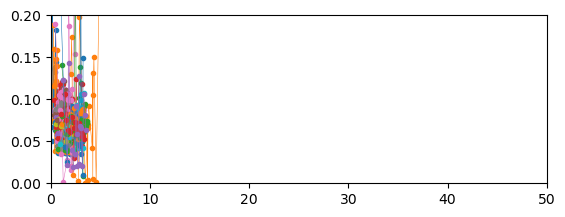

In [12]:
dt = DateTime(2024,5,3,1); ichunk=1
stare1dt, dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv, epsi_tmp = get_chunk( dt, ichunk )

# plot D2 vs rho
clf()
subplot(2,1,1)
plot(m2n.(rhobin), m2n.(D2bin), marker=".", linewidth=0.4)
xlim([0, 50])
ylim([0, 0.2])
gcf()

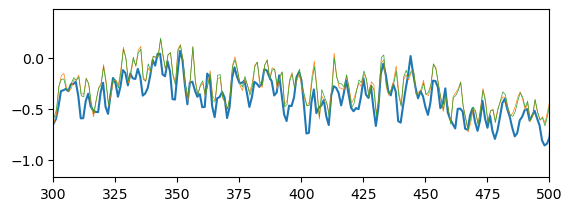

In [13]:
# plot test motion correction
# clf()
# plot_stare_motcor( stare1dt, height, dopplervel, mdv, roll, -pitch, Ur, Vr, -vn1, vn0, -vn2 )
# gcf()
dt = DateTime(2024,5,3,1); ichunk=1
stare1dt, dopplervel, pitch, roll, vn0, vn1, vn2, Ur, Vr, mdv, epsi_tmp = get_chunk( dt, ichunk )

# wt = wtrue_trigs.(dopplervel.-heave, Ur, Vr, pitch*pi/180, roll*pi/180)
wt = wtrue_trigs.(dopplervel.-vn2, Ur, Vr, pitch*pi/180, roll*pi/180)
# wtrue( dopplervel, surgevel, swayvel, heaveveldown, Ur, Vr, roll, pitch )
w  = wtrue.(dopplervel,    0,   0, -vn2, Ur, Vr, -pitch, roll) # looks good, wtrue 1 index early?
w1 = wtrue.(dopplervel, -vn1, vn0, -vn2, Ur, Vr, -pitch, roll)
# vn0, vn1 0.1 horiz velocities that don't have much radial component

clf()
subplot(2,1,1)
plot(mdv)
# plot(mean.(skipmissing.(eachrow(wt))))
plot(eachindex(mdv).+0.2, mean.(skipmissing.(eachrow(w ))), linewidth=0.5)
plot(eachindex(mdv).+0.2, mean.(skipmissing.(eachrow(w1))), linewidth=0.5)
xlim([300, 500])
gcf()

There are still stripes from the ship motion. I suspect it's not synced properly still.

The vertical-mean Doppler velocity (mdv) adjustment completely eliminates the ship motion, but it also reduces variability longer than a few ship wave periods in the motion corrected radial velocity. Could bandpass filter the mdv to restore this low frequency variability.

In [ ]:
# test: compute dissipation for one hour (one file)

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
# lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )
# lidardaydir = lidardaydirs[5]
lidardaydirs = filter( startswith("20240430"), readdir(lidarstemdir) )
lidardaydir = lidardaydirs[1]

dt = Date(lidardaydir, dateformat"yyyymmdd")

epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)

Vn = read_vecnav_dict() # Dict{Symbol, Any}
# Vn = read_daily_Vn( dt )            # Dict
# load daily relative horizontal winds
UV = get_daily_meanuv( dt )

# another file in the same day
lidarfile = filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))[12]
dt = Date(lidardaydir, dateformat"yyyymmdd")
epsi_tmp = Matrix{Union{Missing,Float64}}(missing, 6,ntop)
UV = get_daily_meanuv( dt ) # daily
splt = split(lidarfile, r"[_.]")
dtm = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime

St, _ = read_streamlinexr_stare( dtm )
height = St[:height][1:ntop]
# TO DO: read the next hour to get continuous chunk at end ...
st_chunks, en_chunks = read_stare_time( St )
stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202

for (ichunk, st) in enumerate(st_chunks)
    en = en_chunks[ichunk]
    lidar_clock_fast_by = Millisecond( round(Int64, 1_000 * fit_offset(stare_dt_raw[st])) )
    stare_dt = stare_dt_raw .- lidar_clock_fast_by # synced to within 1 s
    stare1dt = stare_dt[st:en] # subset for this chunk
    
    # read a chunk
    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( dtm, St, Vn, UV, st, en )
    if any(isfinite.(Ur)) && any(isfinite.(Vr))
        # cannot consistently sync heave and dopplervel
        #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
        w = dopplervel .- mdv 
        D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
        epsi_tmp[ichunk,:] = @. epsilon(max(0,A))
    end
end


In [ ]:
# loop through lidar data and compute TKE dissipation rate
# only handles one Stare file at a time
# Use time axis lidar_dt and functions in read_lidar: 
# to query chunks across files.

ntop = 80       # subset vertical levels
timestep = 1.02 # s
lidarstemdir = "./data" # "/Users/deszoeks/Data/EKAMSAT/lidar"
lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) ) # all days
# lidardaydirs = filter( startswith("20240430"), readdir(lidarstemdir) ) # redo 04-30
epsi = Matrix{Union{Missing,Float64}}(missing, 6*24*60, ntop)
lidardtstart = zeros(DateTime, 6*24*60)
lidardtend   = zeros(DateTime, 6*24*60)

if false # | true # comment out to save time
# compute epsilon for all stares 

    Vn = read_vecnav_dict() # Dict{Symbol, Any}

    # for lidardaydir in lidardaydirs[2:16] # files available leg 1
    # for lidardaydir in lidardaydirs[7:16] # files available leg 1
    for lidardaydir in lidardaydirs[17:end] # files available leg 2
    # for lidardaydir in lidardaydirs[:] # all (for 1)
        dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
        print("$(lidardaydir) ")
        # can't sync motion with clock!
        try # load daily vectornav  
            Vn_daily = read_daily_Vn( dt )            # Dict
        catch
            print("no VectorNav for $(dt)")
        end
        try # load daily relative horizontal winds
            UV = get_daily_meanuv( dt )         # NCDataset
        catch
            print("no mean wind for $(dt)\n")
            #save epsilon.jld2 just in case
            # jldopen("epsilon_tmp.jld2", "w+") do file
            #     file["epsilon"] = epsi
        end

        # load hourly lidar stares
        bigind = 0 # index time, save daily
        for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir,lidardaydir)))
            splt = split(lidarfile, r"[_.]")
            dtm = DateTime(splt[3]*splt[4], dateformat"yyyymmddHH") # a DateTime
            print("$(splt[4]) ")
            
            St, _ = read_streamlinexr_stare( dtm )
            height = St[:height][1:ntop]
            # TO DO: read the next hour to get continuous chunk at end ...

            st_chunks, en_chunks = read_stare_time( St )
            stare_dt_raw = @. DateTime(Date(dt)) + Millisecond(round(Int64, St[:time] * 3_600_000 )) # 3202


            # stare_dt = @. ( dt 
            #     + Millisecond(round(Int64, St[:time] * 3_600_000 )) 
            #     - lidar_clock_fast_by )
            for (ichunk, st) in enumerate(st_chunks)
                en = en_chunks[ichunk]
                bigind += 1
                # synchronize clocks using the previously calculated offset function
                lidar_clock_fast_by = Millisecond( round(Int64, 1_000 * fit_offset(stare_dt_raw[st])) )
                stare_dt = stare_dt_raw .- lidar_clock_fast_by # synced to within 1 s
                stare1dt = stare_dt[st:en] # subset for this chunk
                try # read a chunk, collocate wind and VN data
                    dopplervel, pitch, roll, heave, Ur, Vr, mdv = read_stare_chunk( dtm, St, Vn, UV, st, en )
                    if any(isfinite.(Ur)) && any(isfinite.(Vr))
                        # cannot consistently sync heave and dopplervel
                        #w = filter_vel_coherent_heave( dopplervel, pitch*pi/180, roll*pi/180, heave, mdv )
                        w = dopplervel .- mdv 
                        D2bin, rhobin, A, noise = D2_rho_stare( w, pitch*pi/180, roll*pi/180, Ur, Vr )
                        epsi[bigind,:] .= @. epsilon.(max(0,A))
                    else
                        epsi[bigind,:] .= -4 # code for missing wind
                    end
                catch
                        epsi[bigind,:] .= -5 # code for missing data, probably VN missing
                end
                lidardtstart[bigind] = stare_dt[st]
                lidardtend[bigind] = stare_dt[en]
            end
        end
        print("\n")
        #save data daily to epsilon.jld2
        fileout = "epsilon_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
        print("Saving $(fileout)\n")
        jldopen(fileout, "w+") do file
            file["epsilon"] = epsi[1:bigind,:]
            file["start_dt"] = lidardtstart[1:bigind]
            file["end_dt"]   = lidardtend[1:bigind]
        end
    end

end

# notes
# heave channel constant on 2024-5-12
# no mean wind on 2024-05-12
# 20240519 no VectorNav for 2024-05-19 00

In [ ]:

clf()
plot(dtime, linewidth=0.3)
plot(ist, dtime[ist], linestyle="none", marker=".", markersize=1)
plot(ien, dtime[ien], linestyle="none", marker=".", markersize=1)
ylim([DateTime(2024,5,1), DateTime(2024,5,1,3)])
xlim([findfirst(dtime.>DateTime(2024,5,1)), findlast(dtime.<DateTime(2024,5,1,3))])
gcf()



In [ ]:
# compute and save start and end times for stares - commented out to save time
# print warnings to show data availability
# start and end times are already saved with epsilon

if false # | true # save time

    lidardtstart = Vector{DateTime}(undef, 6*24*60)
    lidardtend = Vector{DateTime}(undef, 6*24*60)

    # for lidardaydir in lidardaydirs[2:16] # files available leg 1
    # for lidardaydir in lidardaydirs[2:4] # files available leg 1
    for lidardaydir in lidardaydirs[17:end] # files available leg 2
    # for lidardaydir in lidardaydirs[:] # replace 4-30 data
        dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
        print("$(lidardaydir) ")
        # can't sync motion with clock!
        try # load daily vectornav  
            Vn = read_daily_Vn(dt)            # Dict
        catch
            print("no VectorNav for $(dt)")
        end
        try # load daily relative horizontal winds
            UV = get_daily_meanuv(dt)         # NCDataset
        catch
            print("no mean wind for $(dt)\n")
            #save epsilon.jld2 just in case
            # jldopen("epsilon_tmp.jld2", "w+") do file
            #     file["epsilon"] = epsi
        end

        # load hourly lidar stares
        bigind = 0 # index time, save daily and reset bigind daily
        # read each hour in the day
        for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir, lidardaydir)))
            splt = split(lidarfile, r"[_.]")
            dt = DateTime(splt[3] * splt[4], dateformat"yyyymmddHH") # a DateTime
            print("$(splt[4]):")

            # read 1 hour
            St, _ = read_streamlinexr_stare(dt)
            st_chunks, en_chunks = read_stare_time(St)
            stare_dt = @. ( dt 
                + Millisecond(round(Int64, St[:time] * 3_600_000 ))
                - lidar_clock_fast_by ) # BUG, not updated at time in loop
                # Large errors could occur in the time for long elapsed times since updates.
                # I'm not sure I trust the offset, even if it is calculated properly.
            for (ichunk, st) in enumerate(st_chunks) # find time of each chunk
                en = en_chunks[ichunk]
                bigind += 1
                lidardtstart[bigind] = stare_dt[st]
                lidardtend[bigind]   = stare_dt[en]
            end
        end
        print("\n")
        #save data daily to epsilon.jld2
        fileout = "staredt_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
        print("Saving $(fileout)\n")
        jldopen(fileout, "w") do file
            file["start_dt"] = lidardtstart[1:bigind]
            file["end_dt"]   = lidardtend[1:bigind]
        end
    end
end

Base.Meta.ParseError: ParseError:
# Error @ /home/deszoeks/Projects/ASTRAL/lidar/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X31sdnNjb2RlLXJlbW90ZQ==.jl:44:39
                + Millisecond(round(Int64, St[:time] * 3_600_000 )) ) 
                - lidar_clock_fast_by ) # BUG, not updated at time in loop
#                                     └ ── Expected `end`

In [ ]:
# compute and save start and end times for stares 
# DO NOT OFFSET the times: retain the lidar instrument times!
# print warnings to show data availability
# start and end times are already saved with epsilon, but maybe wrong

lidardaydirs = filter( startswith("2024"), readdir(lidarstemdir) )

if false | true # comment out to save time

    lidardtstart = Vector{DateTime}(undef, 6*24*60)
    lidardtend = Vector{DateTime}(undef, 6*24*60)

    # for lidardaydir in lidardaydirs[2:16] # files available leg 1
    # for lidardaydir in lidardaydirs[2:4] # files available leg 1
    # for lidardaydir in lidardaydirs[17:end] # files available leg 2
    for lidardaydir in lidardaydirs[:]
        dt = Date(lidardaydir, dateformat"yyyymmdd") # a Date
        print("$(lidardaydir) ")
        # check VN motion status was done here

        # load hourly lidar stares
        bigind = 0 # index time, save daily and reset bigind daily
        # read each hour in the day
        for lidarfile in filter(startswith("Stare_116_"), readdir(joinpath(lidarstemdir, lidardaydir)))
            splt = split(lidarfile, r"[_.]")
            dt = DateTime(splt[3] * splt[4], dateformat"yyyymmddHH") # a DateTime
            print("$(splt[4]):")

            # read 1 hour
            St, _ = read_streamlinexr_stare(dt)
            st_chunks, en_chunks = read_stare_time(St)
            stare_dt = @. ( dt 
                + Millisecond(round(Int64, St[:time] * 3_600_000 )) ) 
                # DO NOT SHIFT TIME
                #- lidar_clock_fast_by ) # BUG, not updated at time in loop
                # Large errors could occur in the time for long elapsed times since updates.
                # I'm not sure I trust the offset, even if it is calculated properly.
            for (ichunk, st) in enumerate(st_chunks) # find time of each chunk
                en = en_chunks[ichunk]
                bigind += 1
                lidardtstart[bigind] = stare_dt[st]
                lidardtend[bigind]   = stare_dt[en]
                # epsilon calc. was done here
            end
        end
        print("\n")
        #save data daily
        fileout = "staredt0_$(Dates.format(dt, dateformat"yyyymmdd")).jld2"
        print("Saving $(fileout)\n")
        jldopen(fileout, "w") do file
            file["start_dt"] = lidardtstart[1:bigind]
            file["end_dt"]   = lidardtend[1:bigind]
        end
    end
end

20240428 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240428.jld2
20240429 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240429.jld2
20240430 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240430.jld2
20240501 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240501.jld2
20240502 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240502.jld2
20240503 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240503.jld2
20240504 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240504.jld2
20240505 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_20240505.jld2
20240506 00:01:02:03:04:05:06:07:08:09:10:11:12:13:14:15:16:17:18:19:20:21:22:23:
Saving staredt0_202405

In [32]:
# no file ./epsilon_data/epsilon_tmp.jld2
#=
jldopen("./epsilon_data/epsilon_tmp.jld2", "r") do file
    epsi = file["epsilon"]
    startdt = file["start_dt"]
    enddt = file["end_dt"]
end

pcolormesh(pd(m2n.(epsi)))
=#

In [ ]:
# load whole array of epsilon from all daily files
epsdatapath = "./epsilon_data/"
# ntop = 80
ntime = 150*41

# fills arrays epsi, start_dt, end_dt
function readoneepsifile!(epsi, start_dt, end_dt, count, file)
    f = jldopen(file) # closes once function returns
    tmp = f["epsilon"]
    nadd = size(tmp, 1)
    epsi[count .+ (1:nadd), :] .= tmp
    start_dt[count .+ (1:nadd)] .= f["start_dt"]
    end_dt[  count .+ (1:nadd)] .= f["end_dt"]
    count + nadd
end

epsi = Matrix{Union{Missing, Float64}}(missing, (ntime, ntop))
start_dt = Vector{Union{Missing, DateTime}}(missing, ntime)
end_dt   = Vector{Union{Missing, DateTime}}(missing, ntime)
count = 0
for file in ( readdir(epsdatapath) |> filter(x->startswith(x,"epsilon_") && endswith(x, ".jld2")) )
    count = readoneepsifile!(epsi, start_dt, end_dt, count, joinpath(epsdatapath, file))
    # print(count, " ")
end

# trim out trailing and missing
ii = findall(!ismissing, start_dt[1:count])
epsi = epsi[ii, :]
start_dt = start_dt[ii]
end_dt = end_dt[ii]

it = findfirst(start_dt .> Date(2024,5,15))
start_dt[it] = start_dt[it-1] + Minute(10)

2024-05-13T23:51:36.098

In [ ]:
# load PSL met data
# candidate files in order of preference
files = [ "./data/../PSL/netcdf/EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc",
          "/Users/deszoeks/Projects/ASTRAL/SSTcompare/data/PSL/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc" ]
filename = files[findfirst(isfile, files)]
psl = NCDataset(filename)
 

Dataset: /Users/deszoeks/Projects/ASTRAL/SSTcompare/data/PSL/ASTRAL-nav-met-sea-flux-10min_RV-Thompson_20240428_R1_thru_20240613.nc
Group: /

Dimensions
   time = 6192

Variables
  time   (6192)
    Datatype:    Union{Missing, DateTime} (Float64)
    Dimensions:  time
    Attributes:
     units                = seconds since 2024-01-01 00:00 UTC
     standard_name        = time
     long_name            = time
     comment              = 
     method               = this time marks the beginning of the averaging interval, i.e. this time is the leading bin edge for each bin average. values provided are averages of all samples from this time step to the next time step. Only 1 good data point was required for a valid average to be computed and reported. Data were originally collected at intervals of 5 min (skin ocean temp ROSR), 1 min (radiation, temp, humidity, pressure, rain, sea water, extra met sensor), 10 Hz (wind, fast humidity, GPS, heading, pitch/roll, motion)
     coverage_conten

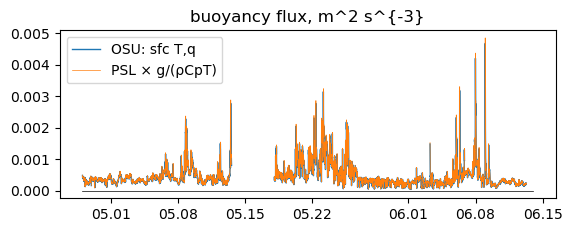

In [36]:
# compute buoyancy flux
# psl[:mo_length]

function calc_bflx(t=psl[:tskin][:].+273.15, q=psl[:qskin][:]*1e-3)
    Cp = 1005
    L = 2.4e6
    g = 9.8
    hs = -psl[:hs_bulk] # dynamic units, now positive-up
    hl = -psl[:hl_bulk] # 
    rho = psl[:rhoair]
    # b_dyn = psl[:hb_bulk]
    wt = hs./(rho*Cp)
    wq = hl./(rho*L )
    fac = @. 1 + 0.608*q
    fac2 = 0.608 ./ fac
    # tv = @. t * fac
    bflx = @. g * ( wt/t + fac2*wq ) # m^2 s^-3
end

bflx0 = calc_bflx(psl[:tskin][:].+273.15, psl[:qskin][:]*1e-3)
bflxa = calc_bflx(psl[:tair][:].+273.15, psl[:qair][:]*1e-3) # makes no difference sea sfc or air
# check buoyancy flux time series and understand units

# plot(psl[:time][:], psl[:qair_2][:], linewidth=0.5) # g/kg

clf()
subplot(2,1,1)
plot(psl[:time][[1, end]], [0, 0], color="k", linewidth=0.5)
plot(psl[:time][:], bflx0, linewidth=1, label="OSU: sfc T,q")
# plot(psl[:time][:], bflxa, linewidth=0.5, label="OSU: air T,q")
plot(psl[:time][:], psl[:hb_bulk][:]/3.5e4, linewidth=0.5, label="PSL × g/(ρCpT)")
title("buoyancy flux, m^2 s^{-3}")
legend()
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
# subplot(2,1,2)
# plot(psl[:time][[1, end]], [0, 0], color="k", linewidth=0.5)
# plot(psl[:time][:], -psl[:hl_bulk][:], linewidth=1, label="lat")
# plot(psl[:time][:], -psl[:hs_bulk][:], linewidth=1, label="sen")
# gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
gcf()

# To get from PSL's dynamic heat flux units for hb_bulk (W/m^2) to buoyancy flux (m^2/s^-3), one multiplies hb_bulk by 
# g / (rho*Cp*T).

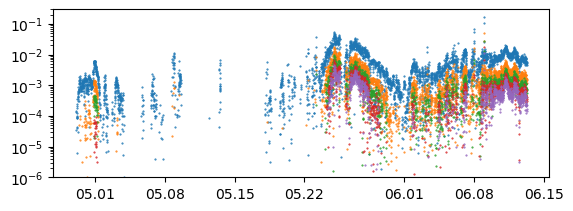

In [99]:
# surface dissipation based on ustar^3
function phi_epsilon(zet) 
    if !ismissing(zet)
        zet<0.1 ? 0.8 + 2*zet : sqrt(zet/0.1) # Hartogensis and De Bruin
    else
        missing
    end
end

# 5.0 ./ psl[:mo_length][:]
# let z = 5, vonk=0.4
#     ustar = psl[:ustar][:]
#     mo_length = psl[:mo_length][:]
#     zet = z ./ mo_length
#     phi_epsilon.(zet) .* ustar.^3 ./ (vonk.*z)
# end

function sfc_epsilon(z; vonk=0.4, mo_length=psl[:mo_length][:], ustar=psl[:ustar][:])
    zet = z ./ mo_length
    phi_epsilon.(zet) .* ustar.^3 ./ (vonk.*z)
end

m2f(x) = ismissing(x) ? false : x

sfc_epsilon(5.0; vonk=0.4)
epsilon0 = hcat([ sfc_epsilon(z) for z in height[1:5] ]...)

posgood(x) = good(x) && x>0
pp = findall( posgood.(epsilon0[:,1]) )

clf()
subplot(2,1,1)
semilogy(psl[:time][pp], epsilon0[pp,:], marker=".", markersize=1, linestyle="none")
ylim([1e-6, 3e-1])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
gcf()

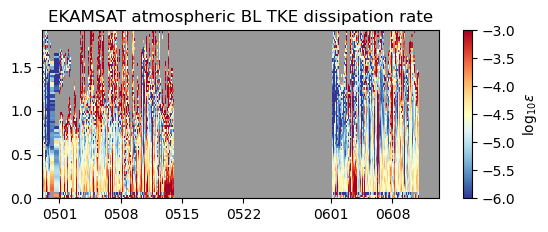

In [101]:
plotfilt(x) = (ismissing(x) || x<=0) ? NaN : x
clean(x) = x<=0 ? missing : x
clf()
subplot(2,1,1)
pcolor(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -3,
        cmap=ColorMap("RdYlBu_r"))
gca().set_facecolor(0.6.+[0,0,0])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
title("EKAMSAT atmospheric BL TKE dissipation rate")
cb = colorbar(); cb.set_label("log"*L"_{10}\epsilon")
gcf()

In [102]:
# methods for averaging DateTimes and TimePeriod

"dt(dt, ...)"
function accudt(f, dt::AbstractVector{DateTime}, args...)
    ms = @. Dates.value(Millisecond(dt - dt[1]))
    return dt[1] .+ Millisecond(round(Int64, f(ms, args...)))
end
# "mean for datetimes" updated 2024-08-01
# meandt(dt::AbstractVector{DateTime}) = first(dt) + MRi( mean(DVM.(dt .- first(dt))) )
"meandt(t, ...)"
function accudt(f, dt::AbstractVector{T}, args...) where T<:TimePeriod
    ms = @. Dates.value(Millisecond(dt))
    return Millisecond(round(Int64, f(ms, args...)))
end

meandt(end_dt .- start_dt) / Millisecond(60_000)
meandt(diff(start_dt)) / Millisecond(60_000)

accudt(median, end_dt .- start_dt) / Millisecond(60_000) # 9:08
accudt(median, diff(start_dt)) / Millisecond(60_000)


10.00725

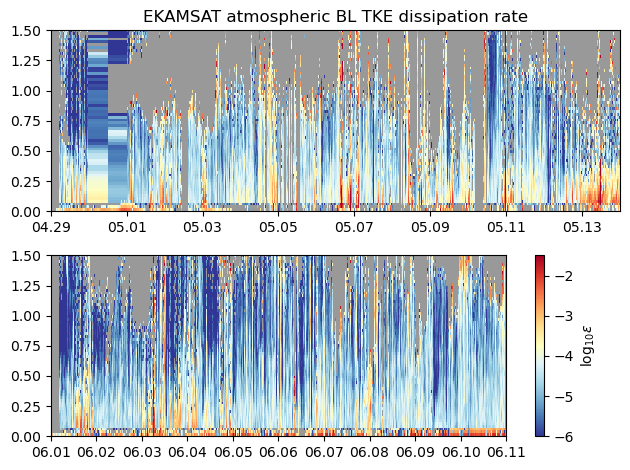

In [113]:
clf()
subplot(2,1,1)
pcolormesh(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
pcolormesh(psl[:time], height[1:4]/1e3, log10.(plotfilt.(pd(epsilon0[:,1:4]))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m%d"))
title("EKAMSAT atmospheric BL TKE dissipation rate")
# plot(psl[:time][:], 0.5*psl[:prate][:], linewidth=0.5, color="blue")
# plot(psl[:time][:], 0.1*psl[:wspd_10][:], linewidth=0.5, color="k")
# plot(psl[:time][:], 0.1*psl[:rspd][:], linewidth=0.5, color="k")
# # plot(psl[:time][:], 0.75 .+ 0.75/180*psl[:rdir][:], linewidth=0.5, color="m")
# plot(psl[:time][:], 1000*bflx0, linewidth=0.5, color="r")
xlim([DateTime(2024,4,29), DateTime(2024,5,14)])
# xlim([DateTime(2024,5,2), DateTime(2024,5,4)])
ylim([0, 1.5])
gca().set_facecolor(0.6.+[0,0,0])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))

subplot(2,1,2)
pcolormesh(psl[:time], height[1:4]/1e3, log10.(plotfilt.(pd(epsilon0[:,1:4]))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
pcolormesh(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
# plot(psl[:time][:], 0.5*psl[:prate][:], linewidth=0.5, color="blue")
# plot(psl[:time][:], 0.1*psl[:wspd_10][:], linewidth=0.5, color="k")
# plot(psl[:time][:], 0.1*psl[:rspd][:], linewidth=0.5, color="k")
# # plot(psl[:time][:], 0.75 .+ 0.75/180*psl[:rdir][:], linewidth=0.5, color="m")
# plot(psl[:time][:], 1000*bflx0, linewidth=0.5, color="r")
xlim([DateTime(2024,6,1), DateTime(2024,6,11)])
# xlim([DateTime(2024,6,2), DateTime(2024,6,4)])
ylim([0, 1.5])
gca().set_facecolor(0.6.+[0,0,0])
gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
cb = colorbar(); cb.set_label("log"*L"_{10}\epsilon")
tight_layout()
gcf()

savefig("ekamsat_MABL_TKEdissipation.png", dpi=400)
# savefig("ekamsat_MABL_TKEdissipation.pdf") # slow
# savefig("ekamsat_MABL_TKEdissipation.svg") # slow
gcf()

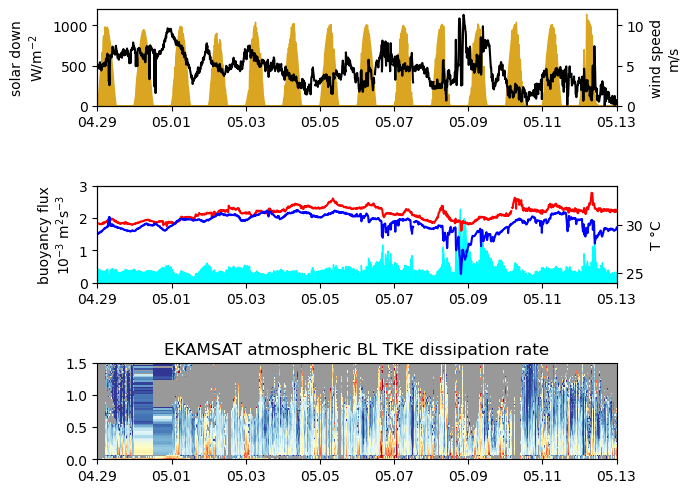

In [ ]:
# replicate DYNAMO plot
tstart = DateTime(2024,4,29)
tend = DateTime(2024,5,13)
clf()
ltax1 = subplot(3,1,1)
rtax1 = ltax1.twinx()
ltax1.fill_between(psl[:time][:], psl[:sw_down][:], color="goldenrod", label="solar down, W/m\$^{-2}\$")
rtax1.plot(psl[:time][:], psl[:wspd_10][:], color="k", label="10 m wind speed, m/s")
ltax1.set_xlim([DateTime(2024,4,29), tend])
rtax1.set_xlim([DateTime(2024,4,29), tend])
ltax1.set_ylim([0, 1200])
rtax1.set_ylim([0, 12])
ltax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
ltax1.set_ylabel("solar down\nW/m\$^{-2}\$")
rtax1.set_ylabel("wind speed\nm/s")

ltax2 = subplot(3,1,2)
rtax2 = ltax2.twinx()
ltax2.fill_between(psl[:time][:], 1e3*bflx0, color="cyan", label="buoyancy flux")
rtax2.plot(psl[:time][:], psl[:tskin][:], color="r", label="SST")
rtax2.plot(psl[:time][:], psl[:tair][:], color="b", label="Tair")
ltax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
ltax2.set_ylim([0, 3])
rtax2.set_ylim([24, 34])
ltax2.set_xlim([DateTime(2024,4,29), tend])
rtax2.set_xlim([DateTime(2024,4,29), tend])
ltax2.set_ylabel("buoyancy flux\n10\$^{-3}\$ m\$^2\$s\$^{-3}\$")
rtax2.set_ylabel("T °C")

ax3 = subplot(3,1,3)
pcolormesh(start_dt, height/1e3, log10.(plotfilt.(pd(epsi))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
pcolormesh(psl[:time], height[1:4]/1e3, log10.(plotfilt.(pd(epsilon0[:,1:4]))), vmin = -6, vmax = -1.5,
        cmap=ColorMap("RdYlBu_r"))
ax3.set_title("EKAMSAT atmospheric BL TKE dissipation rate")
ax3.set_xlim([tstart, tend])
ax3.set_ylim([0, 1.5])
ax3.set_facecolor(0.6.+[0,0,0])
ax3.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m.%d"))
gcf()


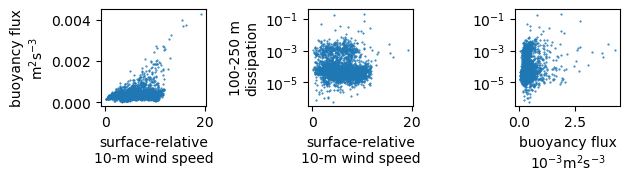

In [166]:
# interpolate psl to lidar time
"convert datetime to Integer milliseconds, which interpolate can handle."
dt2ms(dt, dt0=DateTime(2024,4,1)) = Dates.value(Millisecond(dt - dt0))
"interpolate from psl datetime to lidar dt"
interp_psl_to_lidar(y; psldt=psl[:time][:], lidardt=start_dt) = 
    interpolate( (dt2ms.(psldt), ), y, Gridded(Linear()) )(dt2ms.(lidardt)) # returns a vector
# use-test
bflxi = interp_psl_to_lidar(bflx0)
wspdi = interp_psl_to_lidar(psl[:wspd_10][:])
size(bflxi), size(wspdi), size(start_dt), size(epsi)
clf()
plot(wspdi[si][1:nf], (1:nf)/nf, marker=".", markersize=1, linestyle="none")
gcf()

clf()
subplot(3,3,1)
plot(wspdi[si][1:nf], bflxi[si][1:nf], marker=".", markersize=1, linestyle="none")
ylabel("buoyancy flux\nm\$^2\$s\$^{-3}\$")
xlabel("surface-relative\n10-m wind speed")
subplot(3,3,2)
semilogy(wspdi[si][1:nf], (epsNrSfc[si][1:nf]), marker=".", markersize=1, linestyle="none")
ylabel("100-250 m\ndissipation")
xlabel("surface-relative\n10-m wind speed")
subplot(3,3,3)
semilogy(1e3.*bflxi[si][1:nf], (epsNrSfc[si][1:nf]), marker=".", markersize=1, linestyle="none")
xlabel("buoyancy flux\n10\$^{-3}\$m\$^2\$s\$^{-3}\$")
# ylabel("100-250 m\ndissipation")
tight_layout()
gcf()

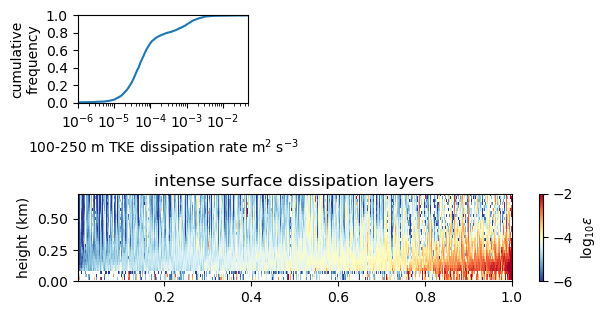

In [132]:
# plot intense surface dissipation

isgood(x) = !ismissing(x) && isfinite(x) && x>=0
good(x) = isgood(x) ? x : 0
goodmean(x; dims) = sum(good.(x), dims=dims)./sum(isgood.(x), dims=dims)

# 100-250 m mean dissipation
epsNrSfc = goodmean(epsi[:,5:10], dims=2)[:,1]
height[1:10]

si = sortperm(epsNrSfc)
nf = sum(isfinite.(epsNrSfc))
irg = 1:nf

clf()
subplot(3,3,1)
semilogx(epsNrSfc[si][irg], (1:nf)/nf)
# plot(bflxi[si][1:nf], (1:nf)/nf, marker=".", markersize=1, linestyle="none")
plot(wspdi[si][1:nf], (1:nf)/nf, marker=".", markersize=1, linestyle="none")
ylim([-0.001, 1.001])
xlim([1e-6, 5e-2])
xlabel("100-250 m TKE dissipation rate m\$^2\$ s\$^{-3}\$")
ylabel("cumulative\nfrequency")
yticks(0:0.2:1)

subplot(3,1,2)
pcolormesh(irg/nf, height/1e3, log10.(pd(epsi[si[irg][1:nf-1],1:ntop-1])), 
    vmin=-6, vmax=-2, cmap=ColorMap("RdYlBu_r"))
# gca().set_facecolor(0.6.+[0,0,0])
ylabel("height (km)")
cb = colorbar(); cb.set_label("log"*L"_{10}\epsilon")
ylim([0, 0.7])
title("intense surface dissipation layers")
tight_layout()
gcf()

Bimodal distribution of TKE dissipation rate. 

Main mode, with 0.8 observations, is around 5x10^-5.

About 1/5 of 100-250 m epsilon measurements are in a secondary (higher)
mode around 10^-3 m^2/s^3.

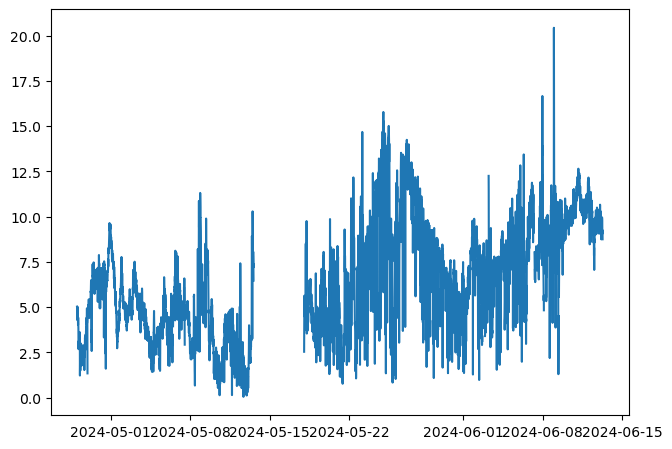

In [399]:
clf()
plot(psl[:time][:], psl[:wspd_10][:])
gcf()

In [ ]:
# Tests

# check that St and Vn data are synced
clf()
subplot(2,1,1)
plot(hp(mdv))
plot(hp(heave))
xlim([400, 440])
# check lags
xc = xcorr( hp(mdv[:]), hp(heave) )
subplot(2,1,2)
plot( -(length(mdv)-1):length(mdv)-1, xc )
xlim([-40, 40])
#length(xc), 2*(length(mdv)-1) + 1
argmax(xc) - length(mdv) # 0-lag center moved to 0
# length(xc), length(mdv), 2*length(heave)


plot(mdv)
# plot(mdv_clean_heave)
# plot(mdv_clean_heavepitch)
# plot(mdv_clean_heavepitch)


plot(stare1dt, heave)
plot(stare1dt, mdv)
plot(stare1dt, mdv - heave) # subtract heave because its downward

## prepare the structure function analysis

In [ ]:
clf()
subplot(2,1,1)
plot(rhobin, D2bin, marker="*")
plot([0, 2.2*mean(rhobin[1:17])], noise .+ A.*[0, 2.2*mean(rhobin[1:17])])
xlim([0, 30])
xlabel(L"\rho = r^{2/3}"
title("TKE dissipation = 1.4 $\times 10^{-4}$")
epsilon(A) # 1.3e-4